In [47]:
import pandas as pd                       
import seaborn as sns                    
import matplotlib.pyplot as plt          
from collections import Counter         
import unicodedata                      
import requests                          
import re                               
from datasets import load_dataset

In [48]:
# Funkcia na odstránenie diakritiky
def remove_diacritics(text):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c)
    )

In [49]:
# Funkcia na predspracovanie komentárov
def preprocess(texts, remove_diacritics_flag=True, remove_stopwords_flag=True):
    # Odstránenie špeciálnych znakov, ponechanie písmen a medzier
    texts = texts.str.replace(r'[^a-zA-ZáäčďéíľĺňóôŕšťúýžÁÄČĎÉÍĽĹŇÓÔŔŠŤÚÝŽ\s]', '', regex=True)

    # Odstránenie diakritiky
    if remove_diacritics_flag:
        texts = texts.apply(remove_diacritics)

    # Odstránenie stop-slov
    if remove_stopwords_flag:
        texts = texts.apply(lambda x: ' '.join([
            word for word in x.split()
            if word.lower() not in ascii_stopwords
        ]))

    return texts

In [50]:
# Načítanie slovenských stop-slov
url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-sk/master/stopwords-sk.txt"
response = requests.get(url)
original_stopwords = response.text.strip().split('\n')

# Stop-slová bez diakritiky pre porovnávanie
ascii_stopwords = set(remove_diacritics(word.strip()) for word in original_stopwords if word.strip())

In [51]:
# Načítanie dát z Hugging Face
dataset = load_dataset('TUKE-KEMT/toxic-sk', split='train')
df = pd.DataFrame(dataset)

print("Dáta načítané z Hugging Face.")

Dáta načítané z Hugging Face.


In [52]:
# Odstránenie prázdnych riadkov a premenovanie stĺpcov
df = df.dropna()
df.rename(columns={'text': 'comments'}, inplace=True)

In [53]:
#Výpočet dĺžky komentárov
df['comment_length'] = df['comments'].apply(len)
print("Priemerná dĺžka komentára:", df['comment_length'].mean())

Priemerná dĺžka komentára: 54.23990918264379


In [54]:
# Pridanie slovenských názvov tried
label_mapping = {0: 'Netoxický', 1: 'Toxický'}
df['label_sk'] = df['label'].map(label_mapping)

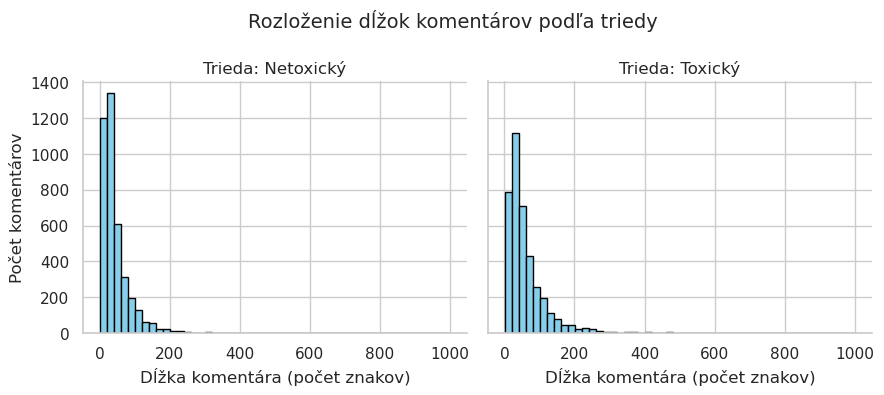

In [63]:
# Vizualizácia dĺžky komentárov
sns.set(style="whitegrid")
graph = sns.FacetGrid(data=df, col='label_sk', height=4, aspect=1.1)
graph.map(plt.hist, 'comment_length', bins=50, color='skyblue', edgecolor='black')
graph.set_axis_labels("Dĺžka komentára (počet znakov)", "Počet komentárov")
graph.set_titles("Trieda: {col_name}")
plt.subplots_adjust(top=0.8)
graph.fig.suptitle("Rozloženie dĺžok komentárov podľa triedy", fontsize=14)
plt.show()

In [56]:
# Priemerná dĺžka komentárov pre každú triedu
for level in df['label'].unique():
    avg_len = df[df['label'] == level]['comment_length'].mean()
    print(f"Priemerná dĺžka komentárov pre triedu {label_mapping[level]}: {avg_len:.2f}")

Priemerná dĺžka komentárov pre triedu Netoxický: 45.33
Priemerná dĺžka komentárov pre triedu Toxický: 63.31


In [57]:
# Čistenie komentárov – aplikovanie preprocessingu
df['processed_comments'] = preprocess(
    df['comments'],
    remove_diacritics_flag=True,
    remove_stopwords_flag=True
)

print("\nUkážka čistenia komentárov:")
print(df[['comments', 'processed_comments']].head(10))


Ukážka čistenia komentárov:
                                            comments  \
0                                       Ďakujeme Vám   
1  "Chcú urobiť výsledok testu a aké sú náklady o...   
2                    chvála bohu mladý chcú tiež žiť   
3  nedozvedeli sme sa nič no ale čo by sme sa aj ...   
4    veľká väčšina s vami nesúhlasí to je váš názor.   
5                   uz ti preplo uplne? jebo drbnutý   
6  informovať politika inej krajiny (akejkolvek) ...   
7                    či sa nehanbíš tu dávať statusy   
8  ved ty vies vsetky len osierat ty mas asi mies...   
9                                 gratulujem a verim   

                                  processed_comments  
0                                           Dakujeme  
1  Chcu urobit vysledok testu naklady obchodu obc...  
2                         chvala bohu mlady chcu zit  
3                 nedozvedeli mohli dozvediet zdroja  
4                      velka vacsina nesuhlasi nazor  
5                       

In [58]:
# Analýza najčastejších slov v toxických komentároch
toxic_df = df[df['label'] == 1]
toxic_words = [
    word for text in toxic_df['processed_comments']
    for word in text.split()
]

top_toxic_words = Counter(toxic_words).most_common(10)

print("\nTop 10 slov v TOXIC komentároch:")
for word, count in top_toxic_words:
    print(f"{word} - {count}")


Top 10 slov v TOXIC komentároch:
ludi - 163
ludia - 153
matovic - 126
pan - 124
clovek - 95
premier - 90
kokot - 85
konecne - 85
igor - 82
uplne - 76


In [59]:
# Uloženie datasetu pre BERT
df_out = df[['processed_comments', 'label']]
df_out.columns = ['text', 'label']
df_out.to_csv('toxic_sk_for_bert.csv', index=False)

print("\nDataset uložený ako 'toxic_sk_for_bert.csv'")


Dataset uložený ako 'toxic_sk_for_bert.csv'
